In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from data.data_handler import SimpleDataset, CondDataset
from models.layers import Reshape
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats.mstats import gmean
import torch.distributions as td
from trainer import Trainer
from cond_trainer import CondTrainer
from torchviz import make_dot

In [2]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"

In [3]:
it = pd.read_csv(data_dir + "ItalyPowerDemand_TEST.txt", sep="  ", header=None)
X = []
t_list = []
for i in range(it.shape[0]):
    it_i = it.iloc[i]
    X.append(it_i.iloc[1:].values)
    t_list.append([it_i.iloc[0]])
X = np.array(X)
t_list = np.array(t_list) - 1

C:\Users\Phili\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
# X = pd.read_csv(data_dir + "stocks_curves.csv").values
# X = X[-1000:]
# y = pd.read_csv(data_dir + "y.csv").values
# y = y[-1000:]
# t_df = pd.read_csv(data_dir + "t.csv")
# t_df = t_df.iloc[-1000:]
# t_list = t_df.t.values

In [5]:
# X = pd.read_csv(data_dir + "funda.csv", index_col = 0)
# X_cols = X.columns
# X = X.values
# y_df = pd.read_csv(data_dir + "secs.csv", index_col = 0)
# secs = y_df.iloc[:,0].unique()
# labels, leves = pd.factorize(y_df.iloc[:,0])
# y_df["label"] = labels
# y = y_df.label.values

In [6]:
# sec_dict = {y_df[y_df.Sector == s].values[0][1]: s for s in secs}

In [7]:
# indus = [sec_dict[i] for i in y]

In [8]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,t_list, test_size = 0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
train_data = SimpleDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = SimpleDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))


In [9]:
X_train.max(axis=0)

array([4.55921754, 4.09934844, 5.29401074, 6.16011741, 6.90164073,
       7.00619666, 5.65427784, 2.35993611, 1.63262807, 2.07314086,
       2.94722043, 3.17504157, 4.49346565, 3.56533233, 2.1846688 ,
       1.78178488, 1.99039513, 2.01976509, 2.88607806, 2.24635148,
       2.97951145, 4.25338263, 3.60246516, 4.27859096])

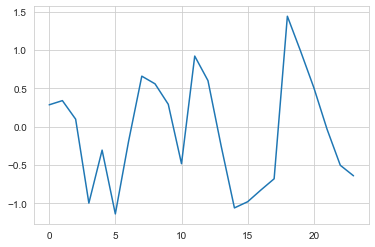

In [10]:
i = np.random.randint(0, len(train_data))
_ = plt.plot(train_data[i][0].detach().numpy())

In [11]:
class Latent(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
        
        self.elu = nn.ELU()
        
    def _rep(self, mu, log_var):
        eps = torch.randn_like(log_var)
        sigma = torch.exp(0.5 * log_var) + 1e-4
        return mu + eps*sigma
    
    def forward(self, x):
        mu = self.mu(x)
        #mu = self.elu(mu)
        log_var = self.log_var(x)
        #log_var = self.elu(log_var)
        z = self._rep(mu, log_var)
        return z, mu, log_var

class Dense(nn.Module):
    def __init__(self, i,o):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(i, o),
            #nn.BatchNorm1d(o),
            nn.ELU()
        )
    def forward(self, x):
        return self.l(x)
    
class Normal(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i,o)
    
    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var) + 1e-4
        return td.Normal(mu, sigma)
    
class ST(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.df = nn.Sequential(
            nn.Linear(i, o),
            #nn.Softmax()
        )
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
    
    def forward(self, x):
        df = self.df(x)
        df = torch.exp(0.5 * df)
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var)
        return td.StudentT(df, mu, sigma)

In [12]:
class VAE(nn.Module):
    def __init__(self, T, n_z):
        super().__init__()
        
        self.mse = nn.MSELoss(reduction="sum")
        
        self.enc = nn.Sequential(
            Dense(T, 64),
            Dense(64, 64),
            Dense(64, 16),
            Latent(16, n_z)
        )
        self.dec = nn.Sequential(
            Dense(n_z, 16),
            Dense(16, 64),
            Dense(64, 64),
            Normal(64, T)
        )
    
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def _dkl(self, mu, log_var):
        alpha = 1.
        vega =1.
        dkl = 0.5 * torch.sum(alpha * mu.pow(2) + log_var.exp() -1 -vega*log_var)
        return dkl
    
    def forward(self, x, beta = 1.0):
        z, mu, log_var = self.enc(x)
        dkl = self._dkl(mu, log_var)
        gen_x = self.dec(z)
        #rcl = self.mse(gen_x, x)
        rcl = -gen_x.log_prob(x).sum()
        loss = rcl + beta*dkl
        
        return gen_x, loss

In [13]:
n_z = 2
vae = VAE(24, n_z)
t = Trainer(vae, train_data, test_data)


In [14]:
losses = t.fit(200, burn_in=0)

Epoch: 0, Train Loss: 33.57, Test Loss:  30.61
Epoch: 10, Train Loss: 14.63, Test Loss:  14.91
Epoch: 20, Train Loss: 12.86, Test Loss:  13.67
Epoch: 30, Train Loss: 11.99, Test Loss:  13.08
Epoch: 40, Train Loss: 11.77, Test Loss:  12.25
Epoch: 50, Train Loss: 10.87, Test Loss:  12.48
Epoch: 60, Train Loss: 10.67, Test Loss:  11.83
Epoch: 70, Train Loss: 10.43, Test Loss:  11.38
Epoch: 80, Train Loss: 10.04, Test Loss:  11.78
Epoch: 90, Train Loss: 10.03, Test Loss:  11.47
Epoch: 100, Train Loss: 9.92, Test Loss:  10.88
Epoch: 110, Train Loss: 9.69, Test Loss:  10.95
Epoch: 120, Train Loss: 9.66, Test Loss:  10.78
Epoch: 130, Train Loss: 9.48, Test Loss:  10.72
Epoch: 140, Train Loss: 9.23, Test Loss:  10.69
Epoch: 150, Train Loss: 9.21, Test Loss:  10.21
Epoch: 160, Train Loss: 9.04, Test Loss:  10.27
Epoch: 170, Train Loss: 9.07, Test Loss:  11.03
Epoch: 180, Train Loss: 9.01, Test Loss:  10.76
Epoch: 190, Train Loss: 8.88, Test Loss:  10.73


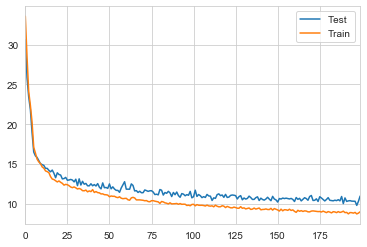

In [15]:
losses[losses < 1000].plot()


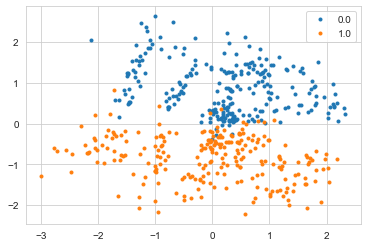

In [16]:
X, t = train_data[:500]
z, mu, log_var = vae.encode(X)
zz = pd.DataFrame(mu.detach().numpy(), columns = ["x", "y"])
zz["t"] = t.detach().numpy()
fig, ax = plt.subplots()
for name, grp in zz.groupby("t"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name, alpha=1)
ax.legend()
plt.show()

In [17]:
z.mean(dim=0), z.std(dim=0)

(tensor([0.0814, 0.0319], grad_fn=<MeanBackward1>),
 tensor([1.0825, 1.0442], grad_fn=<StdBackward1>))

In [18]:
vae.eval()

VAE(
  (mse): MSELoss()
  (enc): Sequential(
    (0): Dense(
      (l): Sequential(
        (0): Linear(in_features=24, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): Dense(
      (l): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (2): Dense(
      (l): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (3): Latent(
      (mu): Linear(in_features=16, out_features=2, bias=True)
      (log_var): Linear(in_features=16, out_features=2, bias=True)
      (elu): ELU(alpha=1.0)
    )
  )
  (dec): Sequential(
    (0): Dense(
      (l): Sequential(
        (0): Linear(in_features=2, out_features=16, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): Dense(
      (l): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (2): Dense(
      (l):

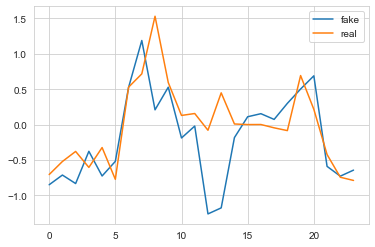

In [19]:
i = np.random.randint(0, len(train_data))
x, y = train_data[i:(i+1)]
z, mu, log_var = vae.encode(x)
gen_x = vae.decode(z)
_ = plt.plot(gen_x.sample().detach().numpy()[0], label="fake")
_ = plt.plot(x.detach().numpy()[0], label="real")
plt.legend()

In [20]:
def grad(x, dist):
    mu = dist.mean
    sigma = dist.scale
    grad = (x - mu) / (sigma.pow(2) + 1e-4)
    return grad

def gradm(x, dist):
    return x - dist

def sgd(x, vae, N=200, alpha=1, eps = 1):
    z_list = []
    x_list = []
    x_list.append(x.unsqueeze(0))
    z, mu, log_var = vae.encode(x)
    z_list.append(mu.unsqueeze(1))
    for i in range(N):
        #eps = eps / np.sqrt(i+1)
        x_z = x + np.sqrt(eps / np.sqrt(i+1)) * torch.randn_like(x)
        #print(x_z.shape, "x")
        z, mu, log_var = vae.encode(x_z)
        dist = vae.decode(z)
        z_list.append(mu.unsqueeze(1))
        g = grad(x_z, dist)
        #print(g.shape, "G")
        x = x - alpha * g #/ np.sqrt(i+1)
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1), torch.cat(x_list)

def adam(x, vae, N, alpha):
    z_list = []
    x_list = []
    beta_1 = 0.9
    beta_2 = 0.999
    eps = 1e-8
    m = 0
    v = 0
    
    z, mu, log_var = vae.encode(x)
    z_list.append(mu.unsqueeze(1))
    x_list.append(x.unsqueeze(0))
    
    
    for i in range(N):
        z, mu, log_var = vae.encode(x)
        gen_x = vae.decode(z)
        g = grad(x, gen_x)
        m = beta_1*m + (1-beta_1)*g
        v = beta_2*v + (1-beta_2)*g.pow(2)
        m_hat = m/(1-beta_1**(i+1))
        v_hat = v/(1-beta_2**(i+1))
        x = x - alpha*m_hat/(torch.sqrt(v_hat)+eps)
        z_list.append(mu.unsqueeze(1))
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1), torch.cat(x_list)

In [21]:
x,t = train_data[4:5]
z_list, x_list = sgd(x,vae, 2000, 0.01, 1)

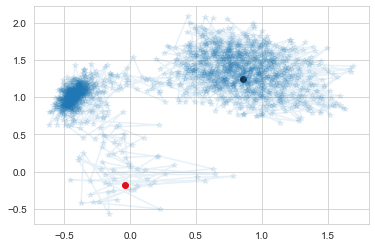

In [22]:
zz = z_list.detach().numpy()
_ = plt.plot(zz[0,:,0], zz[0,:,1],"*-" ,alpha=0.1)
_ = plt.scatter(zz[0,0,0], zz[0,0,1], c="r")
_ = plt.scatter(zz[0,-1,0], zz[0,-1,1], c="black")

In [34]:
print(len(train_data))
with torch.no_grad():
    idx = np.random.choice(np.arange(len(train_data)), 800, replace=False)
    X, t = train_data[idx]
    zz, xx = sgd(X, vae, 5000, 0.001, 1)
    

823


In [35]:

zz_df = pd.DataFrame(zz[:,-1].detach().numpy(), columns = ["x", "y"])
zz_df["class"] = t.detach().numpy()
zz_first_df = pd.DataFrame(zz[:,0].detach().numpy(), columns = ["x", "y"])
zz_first_df["class"] = t.detach().numpy()

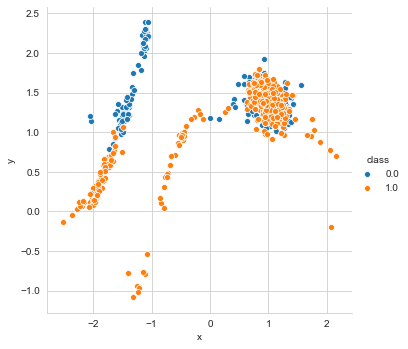

In [36]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="class", data=zz_df, height=5)

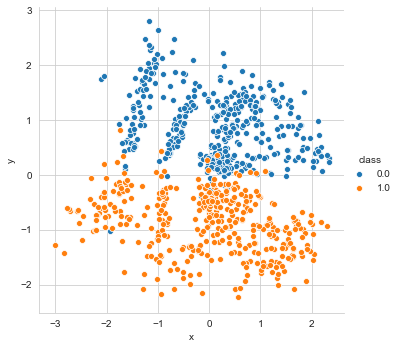

In [26]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="class", data=zz_first_df, height=5)

In [27]:
from sklearn.cluster import KMeans, DBSCAN

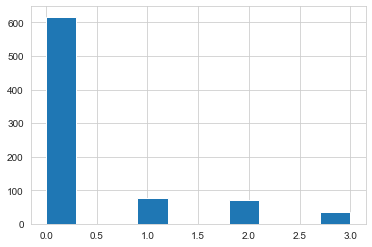

In [28]:
x = xx.detach().numpy()
last = x[-1]
last = last[~np.isnan(last).any(axis=1)]
x_df = pd.DataFrame(scaler.inverse_transform(x[0]))
kk = KMeans(4).fit_predict(x[-1])
x_df["cluster"] = kk
zz_df["cluster"] = kk
_ = plt.hist(kk)


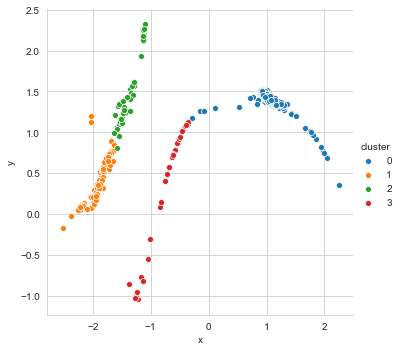

In [29]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="cluster", data=zz_df, height=5)

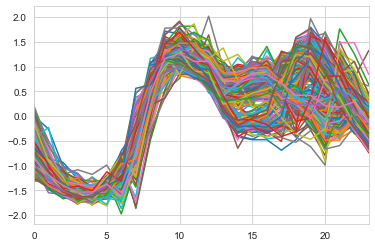

In [30]:
x_df[x_df.cluster == 0].drop("cluster", axis=1).T.plot(legend=False)


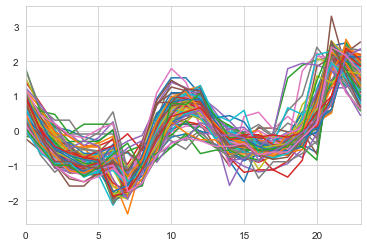

In [31]:
x_df[x_df.cluster == 1].drop("cluster", axis=1).T.plot(legend=False)


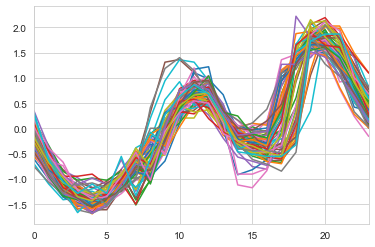

In [32]:
x_df[x_df.cluster == 2].drop("cluster", axis=1).T.plot(legend=False)


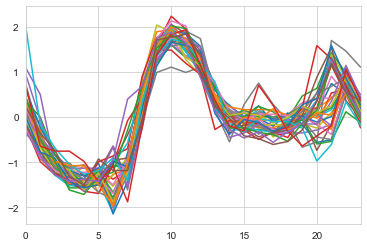

In [33]:
x_df[x_df.cluster == 3].drop("cluster", axis=1).T.plot(legend=False)
